## Victor: Advection - Diffusion equation and implementation in 2D

Tephra fallout is most often modeled using the advection-diffusion equation. It is important to realize that this equation is used in a wide variety of problem solving activities in hazard assessment, including radionuclide dispersion in the atmosphere and contaminant transport in groundwater. For tephra fallout, the advection-diffusion equation is expressed by a simplified mass-conservation equation:
\begin{equation}
\frac{\partial C_j}{\partial t}+w_{x}\frac{\partial C_j}{\partial x}+w_{y}\frac{\partial C_j}{\partial y}-v_{l,j}\frac{\partial C_j}{\partial z}=K\frac{\partial^{2} C_j}{\partial x^{2}}+K\frac{\partial^{2} C_j}{\partial y^{2}}+\Phi
\end{equation}
where, $x$, $y$, and $z$ are spatial coordinates expressed in meters; $C_{j}$ is the mass concentration of particles (kg\,m$^{-3}$) of a given particle size class, $j$; $w_{x}$ and $w_{y}$ are the $x$ and $y$ components of the wind velocity (m\,s$^{-1}$); $K$ is a horizontal diffusion coefficient for tephra in the atmosphere (m$^{2}$ s$^{-1}$); $v_{l,j}$ is the terminal settling velocity (m\,s$^{-1}$) for particles of size class, $j$, as these particles fall through a level in the atmosphere, $l$; $\Phi$ is the change in particle concentration at the source with time, $t$ (kg\,m$^{-3}$\,s$^{-1}$). In this expression, negligible vertical wind velocity and negligible vertical diffusion are assumed. Also, a constant and isotropic horizontal diffusion coefficient ($K$ = $K_{x}$ = $K_{y}$) is assumed.  The terminal settling velocity, $v$, is calculated for each particle size, $j$, at each atmospheric level, $l$, as a function of the particle's Reynolds number, which varies with atmospheric density. Wind velocity is allowed to vary as a function of height in the atmosphere, and may vary laterially within a specific atmospheric level.

Consider the units of this partial differential equation. For example,$\frac{\partial C}{\partial t}$ describes the change in concentration of tephra within some volume of space as a function of time. Dimensionally, $\frac{\partial C}{\partial t} = M/(L^3T)$, where $M$ is mass, $L$ is length, and $T$ is time. Similarly, the wind velocity $w = L/T$, dimensionally, and the diffusion coefficient $K=L^2/T$. Replacing the notion in the above equation with dimensions gives:
\begin{equation}
\frac{M}{L^3 T} + \frac{L}{T} \frac{M}{L^4} + \frac{L}{T} \frac{M}{L^4} - \frac{L}{T} \frac{M}{L^4} =  \frac{L^2}{T} \frac{M}{L^5} + \frac{L^2}{T} \frac{M}{L^5} + \frac{M}{L^3T}
\end{equation}

### Forget the settling velocity for now!
To implement the advection - diffusion equation in 2D, we can drop the settling velocity term (or think of it as making the settling velocity = 0.
\begin{equation}
\frac{\partial C_j}{\partial t}+w_{x}\frac{\partial C_j}{\partial x}+w_{y}\frac{\partial C_j}{\partial y}=K\frac{\partial^{2} C_j}{\partial x^{2}}+K\frac{\partial^{2} C_j}{\partial y^{2}}+\Phi
\end{equation}
Prove to yourself that the units still work out fine.

### Implementation in finite differences
Since we have already implemented the diffusion equation in 2D, and already implemented the advection equation in 2D, using finite differences, it is no problem to combine these solutions algebraically.


In fact, in the following we use the same functions developed previously:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# basic implementation of advection - diffusion

#2D advection - from Numerical Recipes - roughly
def LaxWendroff2Dadvection(u0, u, w_x, v_y, dt, dx, dy):
    a_x = w_x*dt/dx
    a_y = v_y*dt/dy
    
    term_x = np.zeros_like(u0)
    term_y = np.zeros_like(u0)
    
    term_y[1:-1,1:-1]=a_y*(1/2*(u0[2:,1:-1] + u0[1:-1, 1:-1])
                           -1/2*a_y*(u0[2:,1:-1] - u0[1:-1, 1:-1])
                           -1/2*(u0[1:-1, 1:-1] + u0[:-2, 1:-1])
                           + 1/2*a_y*(u0[1:-1, 1:-1] - u0[:-2, 1:-1]))
    
    term_x[1:-1,1:-1]=a_x*(1/2*(u0[1:-1, 2:] + u0[1:-1, 1:-1])
                           -1/2*a_x*(u0[1:-1, 2:] - u0[1:-1, 1:-1])
                           -1/2*(u0[1:-1, 1:-1] + u0[1:-1, :-2])
                           + 1/2*a_x*(u0[1:-1, 1:-1] - u0[1:-1,:-2]))
   
    u[1:-1,1:-1] = u0[1:-1,1:-1] - term_x[1:-1,1:-1] - term_y[1:-1,1:-1]
    
    u0 = u.copy()
    
    return u0, u

# 2D diffusion finite difference - from Numerical Recipes - roughly
def one_time_step_2D_diffusion(u0, u, D, dt, dx2, dy2):
    # Propagate with forward-difference in time, central-difference in space
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + D * dt * (
          (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2
          + (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2 )

    u0 = u.copy()
    return u0, u


### Test run
We develop a simple test run for the advection-diffusion model. A source, $\Phi$, is placed near the center of the grid, in this case emitting heat. 

This simple model led to some problems in the stability criterion for $\Delta t$. the criterion used in the following is too simple, not general enough, but works ok for this problem.

Note that velocity terms (advection) and a diffusivity term (diffusion) are specified:

In [11]:
#run a simple test

#specify model space
w = h = 5000.
# intervals in x-, y- directions, m
dx = dy = 10
dx2 = dx*dx
dy2 = dy*dy

# set the wind speed
w_x = -5 # m/s
v_y = -5 # m/s

Tcool, Thot = 200, 1200

nx, ny = int(w/dx), int(h/dy)
dt = dx/(10*abs(w_x)) #this time step needs to be improved!

D = 50 #m2/s

u0 = Tcool*np.ones((nx, ny))
u = u0.copy()

u0[int(nx/2)-10:int(nx/2)+10, int(ny/2) - 10: int(ny/2) + 10] = Thot
print ("time step = ", dt)

time step =  0.2


### Iterate

The following code steps through time, Note that advection is run first by calling the two step Lax-Wendroff finite difference solution, then the 2D diffusion function is called. That way the functions do not need to be re-written, and a bonus is that the diffusion removes some numerical instability in the advection term with each iteration, for the chosen value of $\Delta t$, which was found by experimentation.

After these function calls, more material/heat is added at the source cells for each iteration.


In [12]:
# Number of timesteps
nsteps = 1500
for m in range(nsteps):
    u0, u = LaxWendroff2Dadvection(u0, u, w_x, v_y, dt, dx, dy)
    u0,u = one_time_step_2D_diffusion(u0, u, D, dt, dx2, dy2)
    u0[int(nx/2)-10:int(nx/2)+10, int(ny/2) - 10: int(ny/2) + 10] = Thot

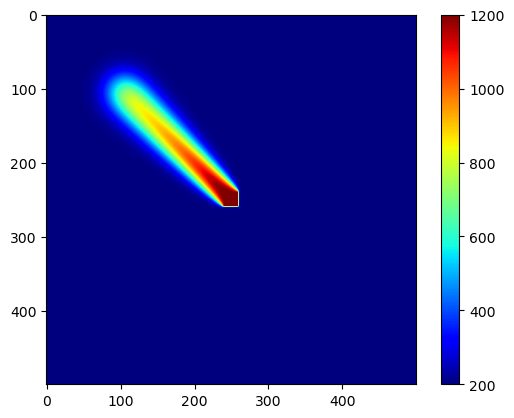

time elapsed =  300.0 s


In [13]:
plt.imshow(u0, cmap='jet', vmin=Tcool,vmax=Thot)
plt.colorbar()
plt.savefig("./advection-diffusion1.png", dpi=300)
plt.show()

print ("time elapsed = ", nsteps*dt, "s")


### getting a more realistic model

The following script is exactly the same, but changes the location of the source, and allows the wind-field to vary spatially. Note that this is accomplished by modifying the Lax-Wendroff advection function.

In [6]:
# basic implementation of advection - diffusion

def LaxWendroff2Dadvection(u0, u, w_x, v_y, dt, dx, dy):
    a_x = dt/dx
    a_y = dt/dy
    
    term_x = np.zeros_like(u0)
    term_y = np.zeros_like(u0)
    
    term_y[1:-1,1:-1]=a_y*v_y[1:-1, 1:-1]*(1/2*(u0[2:,1:-1] + u0[1:-1, 1:-1])
                           -1/2*a_y*v_y[1:-1, 1:-1]*(u0[2:,1:-1] - u0[1:-1, 1:-1])
                           -1/2*(u0[1:-1, 1:-1] + u0[:-2, 1:-1])
                           + 1/2*a_y*v_y[1:-1, 1:-1]*(u0[1:-1, 1:-1] - u0[:-2, 1:-1]))
    
    term_x[1:-1,1:-1]=a_x*w_x[1:-1, 1:-1]*(1/2*(u0[1:-1, 2:] + u0[1:-1, 1:-1])
                           -1/2*a_x*w_x[1:-1, 1:-1]*(u0[1:-1, 2:] - u0[1:-1, 1:-1])
                           -1/2*(u0[1:-1, 1:-1] + u0[1:-1, :-2])
                           + 1/2*a_x*w_x[1:-1, 1:-1]*(u0[1:-1, 1:-1] - u0[1:-1,:-2]))
   
    u[1:-1,1:-1] = u0[1:-1,1:-1] - term_x[1:-1,1:-1] - term_y[1:-1,1:-1]
    
    u0 = u.copy()
    
    return u0, u

# 2D diffusion finite difference - from Gerya (Numerical Geodynamic Modelling)
def one_time_step_2D_diffusion(u0, u, D, dt, dx2, dy2):
    # Propagate with forward-difference in time, central-difference in space
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + D * dt * (
          (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2
          + (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2 )

    u0 = u.copy()
    return u0, u



In [7]:
#run a simple test

#specify model space
w = h = 5000.
# intervals in x-, y- directions, m
dx = dy = 10
dx2 = dx*dx
dy2 = dy*dy



Tcool, Thot = 200, 1200

nx, ny = int(w/dx), int(h/dy)
dt = dx/(8*5) #this time step needs to be improved!

D = 100 #m2/s

u0 = Tcool*np.ones((nx, ny))
u = u0.copy()
v_y = -5 * np.ones((nx, ny))
w_x = 0 * np.ones((nx, ny))
for i in range (0,nx):
    w_x[i:,1:-1] = -(nx - float(i))/100



u0[nx - 10: nx, int(4*ny/5)-10:int(4*ny/5)+10] = Thot
print ("time step = ", dt)

time step =  0.25


In [8]:
# Number of timesteps
nsteps = 4000
for m in range(nsteps):
    u0, u = LaxWendroff2Dadvection(u0, u, w_x, v_y, dt, dx, dy)
    u0,u = one_time_step_2D_diffusion(u0, u, D, dt, dx2, dy2)
    u0[nx - 10: nx, int(4*ny/5)-10:int(4*ny/5)+10] = Thot  #constant source

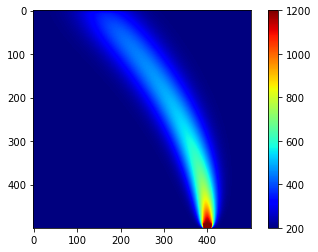

time elapsed =  1000.0 s


In [9]:
plt.imshow(u0, cmap='jet', vmin=Tcool,vmax=Thot)
plt.colorbar()
plt.savefig("./advection-diffusion2.png", dpi=300)
plt.show()

print ("time elapsed = ", nsteps*dt, "s")


### More Applications

1. The above code might work for showing particle concentraton in a bent-over volcanic plume in the atmosphere. The rise velocity, $v_y$, in the above implementation is constant. How would you modify the code to make the plume bend over at a given height? Consider using a simplified version of Briggs' equation where the maximum plume centerline height is:
$$h_{max} = 2.4 \left [\frac{F}{us} \right ]^{1/3} $$
and $F$ is the buoyancy parameter (e.g., 20000 m$^4$/s$^3$), $u$ is the horizontal wind velocity (e.g., 4 m/s), and $s$ is the atmospheric stability factor (e.g., $2 \times 10^{-4}$ s$^{-2}$).

2. Consider a gas advection and diffusion in dry volcanic systems. Bouyancy-driven flow velocities can be calculated:

$$v_y = \frac{-k}{\mu} \left [ \frac{dP_T}{dy} + \rho(P_T) g\right ] $$
where $k$ is permeability (m$^2$), $\mu$ is viscosity (Pa s), $P_T$ is the total gas pressure in pore spaces (Pa), $\rho$ is the gas density (kg/m$^3$) and is a function of the total pressure, and $g$ is gravity (m/s$^{2}$). $\rho(P_T)$ might be found using the ideal gas law:
$$\rho(P_T) = \frac{P_T M}{RT} $$
watch the units here(!): density (g/liter (L)), pressure in atmospheres, temperature in Kelvin, and the gas constant is 0.0821 L atm/mol K. How might you implement these expressions in the advection-diffusion model?
